### A Deep Learning based Efficacy Prediction System for Drug Discovery

Here shows the demo for training process

In [ ]:
########################################################
# All rights reserved. 
# Author: XIE Zhengwei @ Beijing Gigaceuticals Tech Co., Ltd 
#                      @ Peking University International Cancer Institute
# Contact: xiezhengwei@gmail.com
#
#
########################################################
import os
import pdb
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"] = "4"

from keras import backend as K
import utils
# from densenet import DLEPS
import molecule_vae
from dti_predictor_gvae_cnn import DLEPS
# import tensorflow as tf
# from deepPurpose_CNN import CNN
import keras
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping


## Note: protobuf error can be resolved by downgrading it v3.20.1

In [ ]:
# Drug model

dleps_p = DLEPS()
model = dleps_p.model[0]
model.summary()

In [ ]:
# Load dataset

import h5py

h5f = h5py.File('../../data/drugs.h5', 'r')
drugs = h5f['data'][:]
h5f = h5py.File('../../data/genes.h5', 'r')
genes = h5f['data'][:]
h5f = h5py.File('../../data/proteins.h5', 'r')
proteins = h5f['data'][:]
h5f = h5py.File('../../data/pIC50.h5', 'r')
labels = h5f['data'][:]


print(drugs.shape)
print(genes.shape)
print(proteins.shape)
print(labels.shape)

In [ ]:
# Clean data to remove inf, nan, if present any
drugs = utils.clean_data(drugs, fill_value=0)
genes = utils.clean_data(genes, fill_value=0)
proteins = utils.clean_data(proteins, fill_value=0)
labels = utils.clean_data(labels)

In [ ]:
# Split dataset

drug_train, gene_train, protein_train, y_train, \
drug_val, gene_val, protein_val, y_val, \
drug_test, gene_test, protein_test, y_test = utils.train_val_test_split(drugs, genes, proteins, labels)


In [ ]:
print(drug_train.shape)
print(gene_train.shape)
print(protein_train.shape)
print(y_train.shape)
print(drug_val.shape)
print(gene_val.shape)
print(protein_val.shape)
print(y_val.shape)
print(drug_test.shape)
print(gene_test.shape)
print(protein_test.shape)
print(y_test.shape)

## Leveraging transfer learning for pretrained models

In [ ]:
# Freezing already trained layers
# for layers in model.layers[:-8]:
#     layers.trainable = False

In [ ]:
# compile the model
optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae']) 

In [ ]:
# Use ModelCheckpoint to save model and weights
from keras.callbacks import ModelCheckpoint
# filepath = "weights.best.sequential.hdf5" - best
# filepath = "weights.best.sample.hdf5"
# filepath = "test.weights.hdf5"
# filepath = "test.weights.scratch.hdf5"
filepath = "test.weights.complete.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

In [ ]:
# Use the final model to get a single output
epochs = 100
batch_size = 256
early_stopping = EarlyStopping(monitor='val_mae', patience=10)
history = model.fit([drug_train, gene_train, protein_train], y_train, batch_size=batch_size, epochs=epochs, callbacks=[checkpoint, early_stopping], validation_data=([drug_val, gene_val, protein_val], y_val))

In [ ]:
# Plot the training and validation loss
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Plot the training and validation MAE
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.show()

In [10]:
# model.load_weights("test.weights.hdf5")
model.load_weights("test.weights.complete.hdf5")

In [ ]:
# Find the epoch with the minimum validation loss
optimal_epoch = history.history['val_loss'].index(min(history.history['val_loss'])) + 1
print(f"Optimal Epoch: {optimal_epoch} loss: {history.history['val_loss'][optimal_epoch-1]}")

In [ ]:
# Evaluate the model on the test set
results = model.evaluate([drug_test, gene_test, protein_test], y_test)

In [ ]:
# Print the evaluation results
print("Test Loss:", results[0])
print("Test MAE:", results[1])

+---------------------+--------------------+--------------------+
|        Metric       |     Validation     |        Test        |
+---------------------+--------------------+--------------------+
|       MSE Loss      | 0.6446543197611382 | 0.6965219702615247 |
| Pearson Correlation | 0.870112690885802  | 0.8638037658878318 |
|  Concordance Index  | 0.8542904240910614 | 0.8493267162627604 |
+---------------------+--------------------+--------------------+


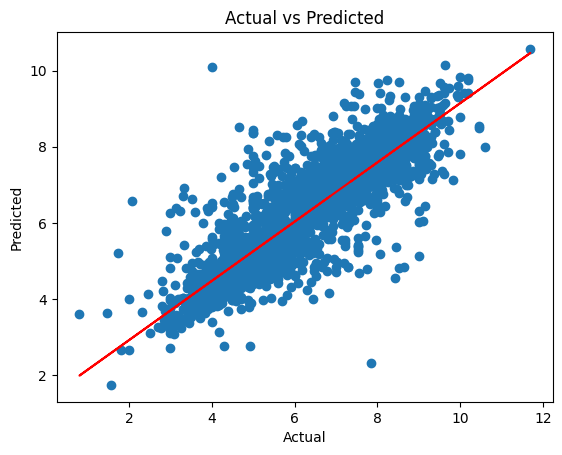

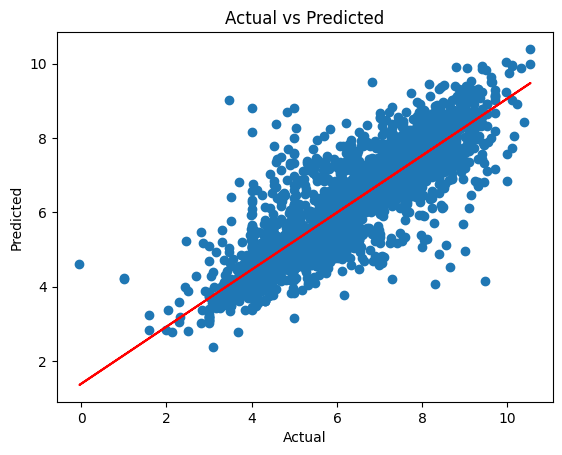

In [11]:
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import numpy as np
from prettytable import PrettyTable

y_pred_val = model.predict([drug_val, gene_val, protein_val])
y_pred_test = model.predict([drug_test, gene_test, protein_test])

# Validation results
val_mse_loss = utils.mse_loss(y_val, y_pred_val.ravel())
val_pearson_corr = utils.pearson_correlation(y_val, y_pred_val.ravel())[0]
val_c_index = utils.c_index(y_val, y_pred_val.ravel())

# Test results
test_mse_loss = utils.mse_loss(y_test, y_pred_test.ravel())
test_pearson_corr = utils.pearson_correlation(y_test, y_pred_test.ravel())[0]
test_c_index = utils.c_index(y_test, y_pred_test.ravel())

table = PrettyTable()
table.field_names = ["Metric", "Validation", "Test"]
table.add_row(["MSE Loss", val_mse_loss, test_mse_loss])
table.add_row(["Pearson Correlation", val_pearson_corr, test_pearson_corr])
table.add_row(["Concordance Index", val_c_index, test_c_index])

# Print results
print(table)

# Plot validation results
plt.scatter(y_val, y_pred_val)
m, b = np.polyfit(y_val, y_pred_val, 1)
plt.plot(y_val, m * y_val + b, 'r')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted')
plt.show()

# Plot validation results
plt.scatter(y_test, y_pred_test)
m, b = np.polyfit(y_test, y_pred_test, 1)
plt.plot(y_test, m * y_test + b, 'r')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted')
plt.show()

## END